# Poincare Map

In [1]:
import rebound
import numpy as np
import math
import ctypes

In [2]:
def hyper(sim):
    ps = sim.particles
    dx  = ps[2].x -ps[0].x
    dy  = ps[2].y -ps[0].y
    dvx = ps[2].vx-ps[0].vx
    dvy = ps[2].vy-ps[0].vy
    return dx*dvx + dy*dvy
def mod2pi(x):
    if x>np.pi:
        return mod2pi(x-2.*np.pi)
    if x<-np.pi:
        return mod2pi(x+2.*np.pi)
    return x

In [16]:
def runone(args):
    N_points_max = 2000
    N_points = 0
    poincare_map = np.zeros((N_points_max,2))
    np.random.seed(args)
    sim = rebound.Simulation.from_file("resonance2.bin")
    sim.particles[2].vx *= np.random.uniform(0.97,1.03)
    sim.t = 0.
    sim.init_megno(1e-16)
    dt = 0.13
    dt_epsilon = 0.001
    sign = hyper(sim)
    while sim.t<15000. and N_points < N_points_max:
        oldt = sim.t
        olddt = sim.dt
        sim.integrate(oldt+dt)
        nsign = hyper(sim)
        if sign*nsign < 0.:
            leftt = oldt
            rightt = sim.t
            sim.dt = -olddt
            while (rightt-leftt > dt_epsilon):
                midt = (leftt+rightt)/2.
                rebound.clibrebound.reb_integrator_reset(ctypes.byref(sim))
                sim.integrate(midt, exact_finish_time=1)
                msign = hyper(sim)
                if msign*sign > 0.:
                    leftt = midt
                    sim.dt = 0.3*olddt
                else:
                    rightt = midt
                    sim.dt = -0.3*olddt
            o = sim.calculate_orbits()
            if o[1].r<o[1].a:
                tp = np.pi*2.
                #phi = o[0].l-2.*o[1].l+o[1].omega+o[1].Omega
                #phi = o[1].omega+o[1].Omega-o[0].omega-o[0].Omega
                phi = mod2pi(o[0].l-2.*o[1].l+o[1].omega+o[1].Omega)
                phid = (tp/o[0].P-2.*tp/o[1].P)/(tp/o[0].P)
                poincare_map[N_points] = [phi,phid]
                N_points += 1
            sim.dt = olddt
            sim.integrate(oldt+dt)
        sign = nsign
    return (poincare_map, sim.calculate_megno())
pool = rebound.InterruptiblePool(24)
res = pool.map(runone,range(240))

<matplotlib.colorbar.Colorbar instance at 0x10e62b200>

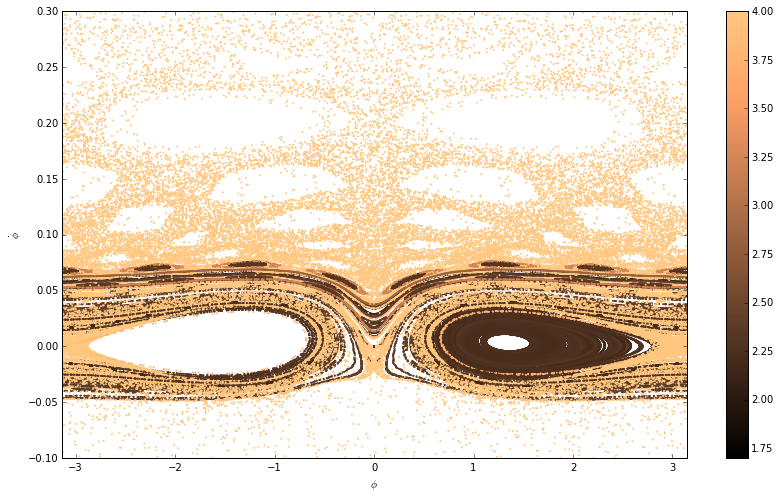

In [19]:
%matplotlib inline  
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,8))
ax = plt.subplot(111)
ax.set_xlabel("$\phi$"); ax.set_ylabel("$\dot{\phi}$")
ax.set_xlim([-np.pi,np.pi])
ax.set_ylim([-0.1,0.3])
cm = plt.cm.get_cmap('copper')
for m, megno in res:
    c=np.empty(len(m[:,0])); c.fill(megno)
    p = ax.scatter(m[:,0],m[:,1],marker=".",c=c, s=15,edgecolor='none', vmin=1.7, vmax=4, cmap=cm)
plt.colorbar(p)

In [61]:
sim = rebound.Simulation.from_file("resonance.bin")
sim.t = 0.
Nplot = 10000
res = np.zeros((Nplot, 2))
times = np.linspace(0.,1884.519,Nplot)
for i, t in enumerate(times):
    sim.integrate(t,exact_finish_time=1)
    o = sim.calculate_orbits()
    phi = mod2pi(o[0].l-2.*o[1].l+o[1].omega+o[1].Omega)
    #phi = o[1].omega+o[1].Omega-o[0].omega-o[0].Omega
    #phi = mod2pi(o[1].l)
    res[i] = [t,phi]


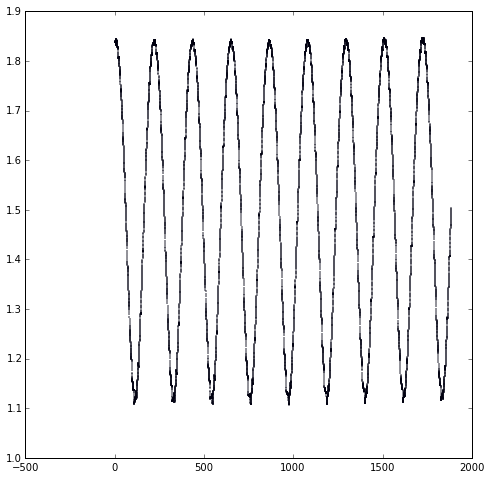

In [62]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
ax.scatter(res[:,0], res[:,1],marker=".",s=1.)
#ax.scatter(res2[:,0], res2[:,1],marker=".",s=1.)

In [84]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(m=1e-3,a=1,e=0.001)
sim.add(m=0.,a=1.65)
sim.move_to_com()
tau = 40000.
def migrationForce(reb_sim):
    ps[2].ax -= ps[2].vx/tau
    ps[2].ay -= ps[2].vy/tau
    ps[2].az -= ps[2].vz/tau
sim.additional_forces = migrationForce
ps = sim.particles    
Nplot = 1000    
res = np.zeros((Nplot, 2))
res2 = np.zeros((Nplot, 2))
times = np.linspace(0.,3000.,Nplot)
for i, t in enumerate(times):
    sim.integrate(t,exact_finish_time=1)
    o = sim.calculate_orbits()
    res[i] = [t,o[0].a]
    res2[i] = [t,o[1].a]
sim.save("resonance2.bin")    